<h1>import and set up some definitions of classes</h1>

<h1>This Model uses only the sixth channel as inputs; drastically different than anything else we have tried</h1>

In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import random
from tensorflow.python.keras.utils.data_utils import Sequence
from sklearn import metrics

In [242]:
#input variables

#model variables
batch_size = 256 #32
epoch_number = 5 #when ready to test, set to 25
learning_rate = 1e-4
n_classes = 1

random.seed(1)

params_train = {'dim': (120,),
          'batch_size': batch_size,
          'n_classes': n_classes,
          'n_channels': 1,
          'shuffle': True}

params_test = {'dim': (120,),
          'batch_size': batch_size,
          'n_classes': n_classes,
          'n_channels': 1,
          'shuffle': False}

In [243]:
#https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(Sequence):

    def __init__(self, list_IDs, labels, batch_size=32, dim=(120,120), n_channels=3,
                 n_classes=2, shuffle=True):
     #   'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def on_epoch_end(self):
    #'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
    #'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
        X_return = np.empty((self.batch_size, 13))
        y = np.empty((self.batch_size), dtype=int)
    

      # Generate data and perform augmentation
        for i, ID in enumerate(list_IDs_temp):
            

            #Load Magnitude array and place in 6th channel
            string = ID.split('_') #list looks like ['HP','00000']
            #print(string)
            string = string[0] +'_'+ string[1] + '_sixth' +'.npy'
            if ID[:2] == 'HP':
                X = np.load('..\\DATA\\HP_sixth\\'+string)[0,:]
            if ID[:2] == 'LP':
                X = np.load('..\\DATA\\LP_sixth\\'+string)[0,:]
            if ID[:2] == 'MP':
                X = np.load('..\\DATA\\MP_sixth\\'+string)[0,:]
            
            #get information:
            mu = [X[0]] #dereddened magnitudes
            mg = [X[6]]
            mr = [X[12]]
            mi = [X[18]]
            mz = [X[24]]

            #pu = [X[i,30]] #petro_r in each band
            #pg = [X[i,36]]
            #pr = [X[i,42]]
            #pi = [X[i,48]]
            #pz = [X[i,54]]

            cu = [X[60]] #colors, dereddened, and each like u-g, g-r ... z
            cg = [X[66]]
            cr = [X[72]]
            ci = [X[78]]
            cz = [X[84]]

            pr_20 = [X[90]] #angular size 
            pr_50 = [X[102]]
            pr_90 = [X[114]]


            X_return[i,:] = np.array((mu+mg+mr+mi+mz+cu+cg+cr+ci+cz+pr_20+pr_50+pr_90))
            
            # Store class
            y[i] = self.labels[ID]
            #determine which class it should be...
            y[i] = int(round((y[i] / 0.4)*(self.n_classes-1),0))
            if y[i] > self.n_classes - 1: #if above 0.4, essentially a far outlier: set to our highest redshift bin.
                y[i] = self.n_classes - 1
    
        if self.n_classes > 2:
            return X_return, keras.utils.to_categorical(y, num_classes=self.n_classes)
        else:
            return X_return, y

    def __len__(self):
    #'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
    #  'Generate one batch of data'
      # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

      # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

<h1>Set up structure of training data</h1>

In [244]:
#targets are generated in a technical notebook, load them in here.
with open("..\\misc\\Z_Spectro.txt","r") as inf:
    targets = eval(inf.read()) #is a dictionary that looks like: {alias:Spectro_Z}


In [245]:

data_list = os.listdir("..\\DATA\\HP_inputs")
random.shuffle(data_list)

for i,file in enumerate(data_list):
    data_list[i] = file.split('.')[0]

LP_data_list = os.listdir("..\\DATA\\LP_inputs")
random.shuffle(LP_data_list)

for i,file in enumerate(LP_data_list):
    LP_data_list[i] = file.split('.')[0]
    
MP_data_list = os.listdir("..\\DATA\\MP_inputs")
random.shuffle(MP_data_list)

for i,file in enumerate(MP_data_list):
    MP_data_list[i] = file.split('.')[0]

data_list = data_list + LP_data_list + MP_data_list

In [246]:
"""
last= -1.0 #accept first value
limit = 0.055
list_for_this = []
list_to_save = []
for i,file in enumerate(data_list):
    if ((last-limit) < targets[file] < (last+limit)) == False :
        list_for_this.append(targets[file])
        list_to_save.append(file)
    last = targets[file]

array_binned = np.round((np.array(list_for_this)/0.9)*100)
print(np.size(array_binned))

bins = np.linspace(0,100,100)
plt.hist(array_binned,bins)
plt.show()
#draw 200 from 0, 3000 from 1-25, 200 from 25 to 0.35, 25 from 0.35 to end. gives me ~ 77,000 training examples (enough??)
np.save('..\\misc\\train_data_uniform_in_Z.npy',np.array(list_to_save))
"""
train_list = np.load('..\\misc\\train_data_uniform_in_Z.npy').tolist()

In [247]:
"""
for i in range(len(training_list)): #now get rid of the training data in our data_list
    data_list.remove(training_list[i])

print(len(data_list))

#that took a while:
np.save('..\\misc\\val_and_test_data_uniform_in_Z.npy',data_list)
"""
data_list = np.load('..\\misc\\val_and_test_data_uniform_in_Z.npy').tolist()

In [248]:
random.seed(1)
random.shuffle(data_list)
index_one = int(len(data_list)/3)
val_list = data_list[0:index_one]
test_list = data_list[index_one::]

In [249]:
partition = {'train':train_list,'validation':val_list,'test':test_list}

In [250]:
#how many steps are in an epoch?
steps_to_take = int(len(train_list)/batch_size)
val_steps_to_take = int(len(val_list)/batch_size)
test_steps_to_take = int(len(test_list)/batch_size)

                #typically be equal to the number of unique samples if your dataset
                #divided by the batch size.

print(steps_to_take)
print(val_steps_to_take)
print(test_steps_to_take)

231
72
144


In [251]:
training_generator = DataGenerator(partition['train'], targets, **params_train) #we want to shuffle these inputs
validation_generator = DataGenerator(partition['validation'], targets, **params_test) #but not the val or test; need order for
test_generator = DataGenerator(partition['test'], targets, **params_test)#analysis; shouldn't matter 'cause not training on them

<h1>Model set-up, callbacks</h1>

In [252]:
#so this is pretty neat, you can create a keras callback to display on tensorboard using a simplified summary tf api

#and also this is an example of how to change the lr on the fly, which is pretty handy
#https://keras.io/callbacks/


def lr_schedule(epoch,lr):

#Returns a custom learning rate that decreases as epochs progress.
    if epoch > 1:
        lr = 1e-5
    if epoch > 2:
        lr = 1e-6
    if epoch > 3:
        lr = 5e-7
    if epoch > 4:
        lr = 1e-7

    tf.summary.scalar('learning_rate', tensor=lr)
    return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

#logdir="summaries/scalars/" + str(datetime.datetime.now().timestamp())
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
#                                                   histogram_freq=1,
#                                                   write_graph=False,
#                                                   write_grads=True,)
#                                                   #write_images=True)
#will it still print stuff

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
#                             patience=2, min_lr=1e-8)

In [253]:
"""
def create_model(learning_rate=learning_rate):
    
    model = keras.Sequential([])
    model.add(keras.layers.Dense(input_shape=(13,),units=13,activation=keras.activations.linear))
    #model.add(keras.layers.Dropout(rate=0.25))
    #model.add(keras.layers.Dense(units=6,activation=keras.activations.linear))
    model.add(keras.layers.Dropout(rate=0.25))
    #model.add(keras.layers.Dense(units=6,activation=keras.activations.linear))
    #model.add(keras.layers.Dropout(rate=0.25))
    #model.add(keras.layers.Dense(units=6,activation=keras.activations.linear)) #tf.nn.relu
    #model.add(keras.layers.Dropout(rate=0.25))
    model.add(keras.layers.Dense(units=params_train['n_classes'],activation=keras.activations.linear))
    #RMS = keras.optimizers.RMSprop(learning_rate=learning_rate)
    adam = keras.optimizers.Adam(lr=learning_rate, clipnorm=0.1)
    model.compile(optimizer=adam, loss=keras.losses.logcosh) 
    return(model)
"""

"\ndef create_model(learning_rate=learning_rate):\n    \n    model = keras.Sequential([])\n    model.add(keras.layers.Dense(input_shape=(13,),units=13,activation=keras.activations.linear))\n    #model.add(keras.layers.Dropout(rate=0.25))\n    #model.add(keras.layers.Dense(units=6,activation=keras.activations.linear))\n    model.add(keras.layers.Dropout(rate=0.25))\n    #model.add(keras.layers.Dense(units=6,activation=keras.activations.linear))\n    #model.add(keras.layers.Dropout(rate=0.25))\n    #model.add(keras.layers.Dense(units=6,activation=keras.activations.linear)) #tf.nn.relu\n    #model.add(keras.layers.Dropout(rate=0.25))\n    model.add(keras.layers.Dense(units=params_train['n_classes'],activation=keras.activations.linear))\n    #RMS = keras.optimizers.RMSprop(learning_rate=learning_rate)\n    adam = keras.optimizers.Adam(lr=learning_rate, clipnorm=0.1)\n    model.compile(optimizer=adam, loss=keras.losses.logcosh) \n    return(model)\n"

In [254]:

def create_model(learning_rate=learning_rate):
    
    model = keras.Sequential([])
    model.add(keras.layers.Dense(input_shape=(13,),units=13,activation=keras.activations.linear))
    model.add(keras.layers.Dropout(rate=0.15))
    model.add(keras.layers.Dense(units=6,activation=keras.activations.linear))
    model.add(keras.layers.Dropout(rate=0.15))
    model.add(keras.layers.Dense(units=6,activation=keras.activations.linear))
    model.add(keras.layers.Dropout(rate=0.15))
    model.add(keras.layers.Dense(units=6,activation=keras.activations.linear)) #tf.nn.relu
    model.add(keras.layers.Dropout(rate=0.15))
    model.add(keras.layers.Dense(units=params_train['n_classes'],activation=keras.activations.linear))
    
    #RMS = keras.optimizers.RMSprop(learning_rate=learning_rate)
    adam = keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=adam, loss=keras.losses.mse) 
    return(model)


In [255]:
filepath = "..\\saved_models\\DNN_MLP_10_11_19.hdf5"
#ModelCheckpointCB = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
ModelCheckpointCB = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

In [256]:
keras.backend.clear_session()
model = create_model(learning_rate = learning_rate)

<h1>Train Model</h1>

In [257]:
hist = model.fit_generator(generator=training_generator,
                    steps_per_epoch=steps_to_take, 
                    epochs=epoch_number,
                    validation_data=validation_generator,
                    validation_steps=val_steps_to_take,
                    initial_epoch=0,
                    verbose=1,
                    callbacks=[ModelCheckpointCB,lr_callback])

Epoch 1/5
72/72 [==============================] - 381s 5s/step - loss: 6.6005

Epoch 00001: val_loss improved from inf to 6.60051, saving model to ..\saved_models\DNN_MLP_10_11_19.hdf5
231/231 [==============================] - 1236s 5s/step - loss: 100.3918 - val_loss: 6.6005
Epoch 2/5
72/72 [==============================] - 375s 5s/step - loss: 1.3537

Epoch 00002: val_loss improved from 6.60051 to 1.35371, saving model to ..\saved_models\DNN_MLP_10_11_19.hdf5
231/231 [==============================] - 1453s 6s/step - loss: 40.4469 - val_loss: 1.3537
Epoch 3/5
72/72 [==============================] - 376s 5s/step - loss: 1.1828

Epoch 00003: val_loss improved from 1.35371 to 1.18275, saving model to ..\saved_models\DNN_MLP_10_11_19.hdf5
231/231 [==============================] - 1433s 6s/step - loss: 30.3903 - val_loss: 1.1828
Epoch 4/5
72/72 [==============================] - 467s 6s/step - loss: 1.1637

Epoch 00004: val_loss improved from 1.18275 to 1.16370, saving model to ..\sa

In [ ]:
#training data from the model ...10_10_19...
"""

Epoch 1/5
923/924 [============================>.] - ETA: 3s - loss: 13.0287
Epoch 00001: val_loss improved from inf to 0.01048, saving model to ..\saved_models\spectro_DNN_10_10_19.hdf5
924/924 [==============================] - 3647s 4s/step - loss: 13.0147 - val_loss: 0.0105
Epoch 2/5
923/924 [============================>.] - ETA: 2s - loss: 0.0105
Epoch 00002: val_loss improved from 0.01048 to 0.00002, saving model to ..\saved_models\spectro_DNN_10_10_19.hdf5
924/924 [==============================] - 2714s 3s/step - loss: 0.0104 - val_loss: 1.7160e-05
Epoch 3/5
923/924 [============================>.] - ETA: 33s - loss: 0.0053 
Epoch 00003: val_loss improved from 0.00002 to 0.00000, saving model to ..\saved_models\spectro_DNN_10_10_19.hdf5
924/924 [==============================] - 31743s 34s/step - loss: 0.0053 - val_loss: 1.5744e-06
Epoch 4/5
923/924 [============================>.] - ETA: 2s - loss: 0.0040
Epoch 00004: val_loss did not improve from 0.00000
924/924 [==============================] - 2485s 3s/step - loss: 0.0040 - val_loss: 3.3565e-06
Epoch 5/5
923/924 [============================>.] - ETA: 3s - loss: 0.0038
Epoch 00005: val_loss did not improve from 0.00000
924/924 [==============================] - 4427s 5s/step - loss: 0.0038 - val_loss: 2.6210e-06
"""

source list

Morphology:
https://arxiv.org/pdf/1711.05744.pdf

https://arxiv.org/pdf/1807.00807.pdf

https://arxiv.org/pdf/1812.02183.pdf


Coding sources:
https://github.com/jameslawlor/kaggle_galaxy_zoo/blob/master/galaxy_zoo_keras.ipynb

https://github.com/khanx169/DL_DES

https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

https://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions/48097478


this is where to download galaxies using SQL:
http://skyserver.sdss.org/dr7/en/tools/search/sql.asp


ideas:

implement the fair splitting function from scipy Gautham told you about

Get better hardware to increase batchsize to something reasonable

Get the morphological classifications into another directory, load them in the augmentation, becasuse we want to compare/make updates to the morphology section. because the R_90 takes up 12 spaces usually, last 6 can just be changed to the loaded in values easy. We want to use this to see if our morphological input helps at all, escpexially for low level regressors like this one

<h1>Analysis</h1>

In [258]:
model.load_weights(filepath)

#model.evaluate_generator(generator=validation_generator,
#                        steps=val_steps_to_take,
#                        verbose=1)

Val_pred = model.predict_generator(generator=validation_generator,
    steps=val_steps_to_take,
    verbose=1)


72/72 [==============================] - 7s 93ms/step


In [259]:
np.shape(Val_pred)

(18432, 1)

In [ ]:
print(np.amax(Val_pred))
print(np.argmax(Val_pred))
print(np.argmin(Val_pred))
len(Val_pred[0])

prediction bias (<z>) = -6.32151629983858
Median absolute deviation (MAD) =  2.160406368704404
outlier fraction (eta) = 0.04318576388888889


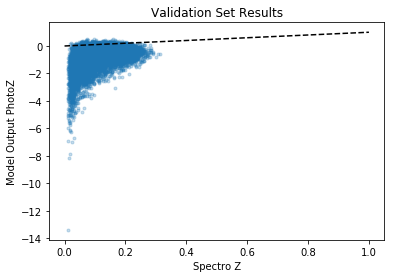

In [262]:
#import Spectro Redshift Labels
#actually, these are our targets and are already imported under the variable name 'targets'

X  = []
Y = Val_pred[:,0]
""" #only neccessary when we have multiple classes
for i in range(len(Val_pred)):
    Y[i] = np.where(Val_pred[i] == np.amax(Val_pred[i,1::]))[0] #first find where the maximum element is
Y = Y*0.9/(n_classes -1) #next scale the results between 0 < 0.9
"""

if validation_generator.n_classes > 2:
    new_Y = np.empty((len(validation_generator.list_IDs)))
    for i in range(validation_generator.n_classes):
        new_Y[i] = np.argmax(Y[i,:])
    Y = (new_Y/validation_generator.n_classes)*0.4
for label in validation_generator.list_IDs:
    X.append(targets[label])
    
Y = np.array(Y)
X = np.array(X)

plt.plot(X[0:len(Y)],Y,'.',alpha=0.25)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Spectro Z')
plt.ylabel('Model Output PhotoZ')
plt.title('Validation Set Results')

#according to cohen et al 2000, we can evaluate our model using some better understood statistics invarient under N
residuals = ((X[0:len(Y)] - Y)/ (1 + Y))
prediction_bias = np.mean(residuals)
MAD = 1.4826*np.median(abs(residuals - np.median(residuals))) #median absolute deviation
outlier_fraction_eta = len(residuals[residuals > 5*MAD])/len(residuals)

print('prediction bias (<z>) =', prediction_bias)
print('Median absolute deviation (MAD) = ', MAD)
print('outlier fraction (eta) =', outlier_fraction_eta)
#plt.text(0.05,-0.18,'prediction bias (<z>) =' + str(round(prediction_bias,3)))
#plt.text(0.05,-0.23,'Median absolute deviation (MAD) = ' + str(round(MAD,3)))
#plt.text(0.05,-0.28,'outlier fraction (eta) = ' + str(round(outlier_fraction_eta,3)))


#plt.text(0.1,0.8,'RMSE =' + str(round(RMSE,4)))
plt.savefig('..\\outputs\\Validation.png')
plt.show()

In [ ]:
#targets are generated in a technical notebook, load them in here.
with open("..\\misc\\Z_Photo.txt","r") as inf:
    Photo_dict = eval(inf.read()) #is a dictionary that looks like: {alias:Photo_Z}
    
z_spectro = []
z_photo = []
for i in range(len(validation_generator.list_IDs)):
    z_spectro.append(validation_generator.labels[validation_generator.list_IDs[i]])
    if 0.0< validation_generator.labels[validation_generator.list_IDs[i]] < 1.0==False:
        print('whoops: ',  validation_generator.labels[validation_generator.list_IDs[i]] )
    z_photo.append(Photo_dict[validation_generator.list_IDs[i]])
    
Y = np.array(z_photo)
X = np.array(z_spectro)

plt.plot(X[0:len(Y)],Y,'.',alpha=0.25)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Spectro Z')
plt.ylabel('SDSS PhotoZ')
plt.title('SDSS PhotoZ vs SpectroZ')

#according to cohen et al 2000, we can evaluate our model using some better understood statistics invarient under N
residuals = ((X[0:len(Y)] - Y)/ (1 + Y))
prediction_bias = np.mean(residuals)
MAD = 1.4826*np.median(abs(residuals - np.median(residuals))) #median absolute deviation
outlier_fraction_eta = len(residuals[residuals > 5*MAD])/len(residuals)

print('prediction bias (<z>) =', prediction_bias)
print('Median absolute deviation (MAD) = ', MAD)
print('outlier fraction (eta) =', outlier_fraction_eta)
#plt.text(0.05,-0.18,'prediction bias (<z>) =' + str(round(prediction_bias,3)))
#plt.text(0.05,-0.23,'Median absolute deviation (MAD) = ' + str(round(MAD,3)))
#plt.text(0.05,-0.28,'outlier fraction (eta) = ' + str(round(outlier_fraction_eta,3)))

plt.ylim(-0.01,0.4)
plt.xlim(-0.01,0.4)
#plt.text(0.1,0.8,'RMSE =' + str(round(RMSE,4)))
plt.savefig('..\\outputs\\Original.png')
plt.show()

In [ ]:
with open("..\\misc\\Z_Photo.txt","r") as inf:
    Photo_dict = eval(inf.read()) #is a dictionary that looks like: {alias:Photo_Z}
    
z_spectro = []
z_photo = []
for i in range(len(training_generator.list_IDs)):
    z_spectro.append(training_generator.labels[training_generator.list_IDs[i]])
    if 0.0< training_generator.labels[training_generator.list_IDs[i]] < 1.0==False:
        print('whoops: ',  training_generator.labels[training_generator.list_IDs[i]] )
        